# Import backage

In [1]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
%matplotlib inline

In [2]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from train import train
from train import train_plus
from models.models_new import Renorm_Dynamic
from dynamic_models_sis_new import Simple_Spring_Model
from vector_field import mesh
from vector_field import transit
from datetime import datetime
t0 = datetime.now()


use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')
device

device(type='cuda', index=0)

# Generate data

In [15]:
mul_batch_size = [0,5000,3000,1000]#[0,10,4500,1500]
sigma = 0.03
rou = -0.5
steps = 7
dt = 0.01
interval = 100
steps2 = 10
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
spring = Simple_Spring_Model(device=device)
test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10*interval, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt,interval=interval) 
train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps*interval, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=dt,interval=interval)

# Train

In [ ]:
sz = 4
scale = 2
L = 1
mae2_w = 3
T_total = 30001
eis_nisp, term1s_nisp, term2s_nisp, losses_nisp, MAEs_mstep_nisp, net = train_plus(train_data=train_data, test_data=test_data, 
                                                                         sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                         mae2_w=mae2_w, dt=dt, T2=T_total,framework='nis',steps2=steps2,interval=interval)
torch.save(net.state_dict(), 'mdl_data/nis steps10 exp-0.2t interval100 seed=0.mdl')

check point-------o_0-> 18:12:31.868619; lasting 1:17:58.023629 seconds
Epoch: 0
Train loss: 0.2163
dEI: 0.5850
term1: -0.2545
term2: 1.4244
Test multistep loss: 0.4563
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 18:12:38.438069; lasting 0:00:06.569450 seconds
check point-------o_0-> 18:14:19.635478; lasting 0:01:41.197409 seconds
Epoch: 500
Train loss: 0.0276
dEI: 1.0743
term1: 0.8422
term2: 1.3065
Test multistep loss: 0.2021
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 18:14:28.561806; lasting 0:00:08.926328 seconds
check point-------o_0-> 18:16:09.024692; lasting 0:01:40.462886 seconds
Epoch: 1000
Train loss: 0.0170
dEI: 1.3587
term1: 1.3931
term2: 1.3243
Test multistep loss: 0.2127
--------------------------------------------------------------------------------------------------------

In [ ]:
eis_nisp, term1s_nisp, term2s_nisp, losses_nisp, MAEs_mstep_nisp, net_nisp = train_plus(train_data=train_data, test_data=test_data, 
                                                                         sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                         mae2_w=mae2_w, dt=dt, T2=T_total,framework='nis+',steps2=steps2,interval=interval)
torch.save(net_nisp.state_dict(), 'mdl_data/nisp steps10 exp-0.2t interval100 seed=0.mdl')

# Plot

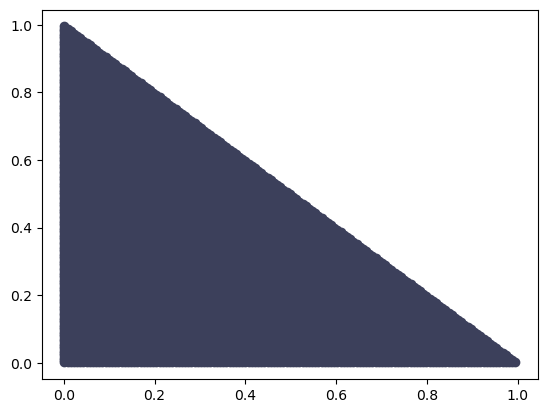

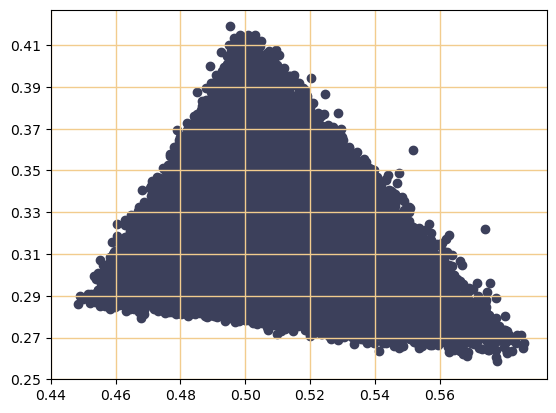

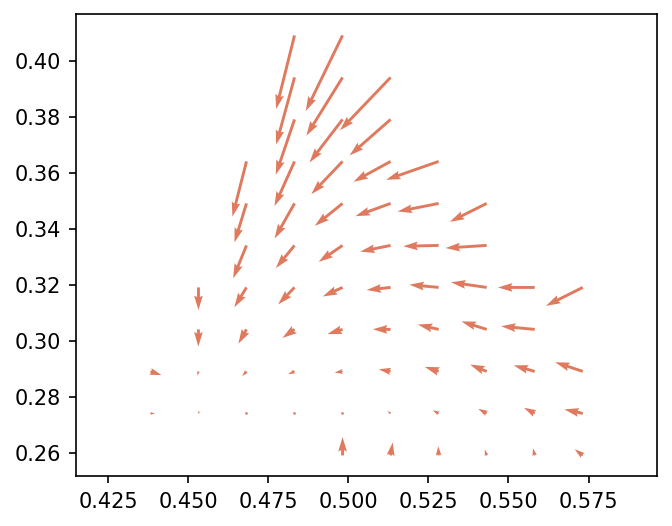

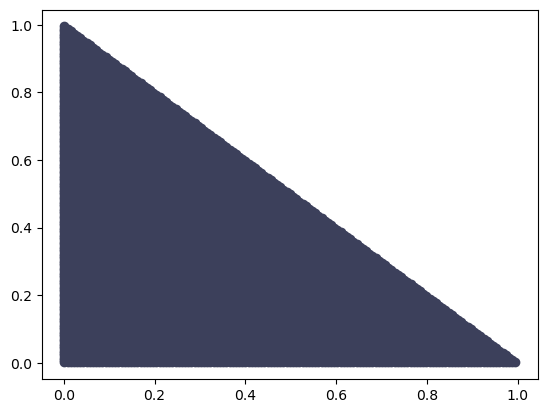

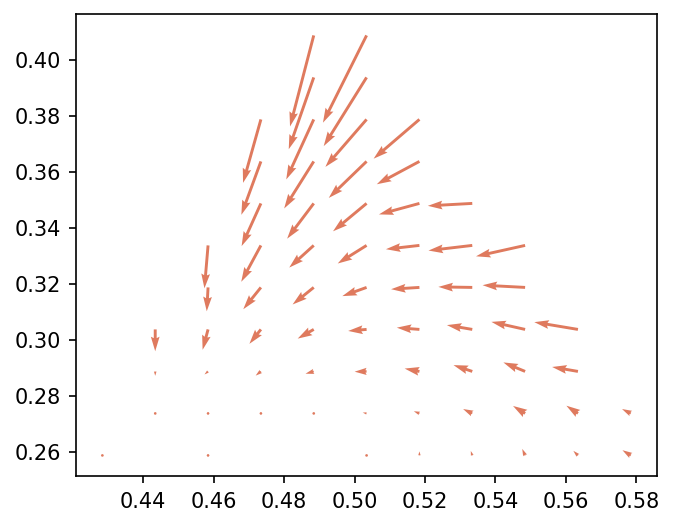

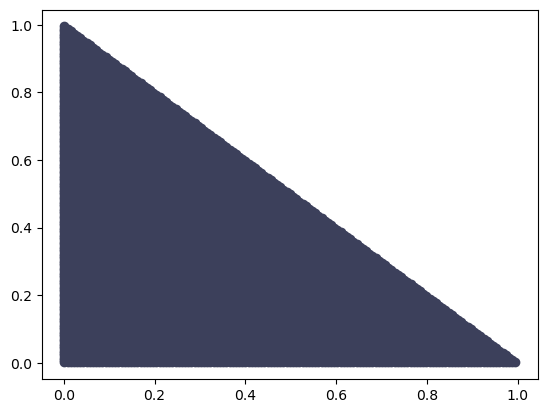

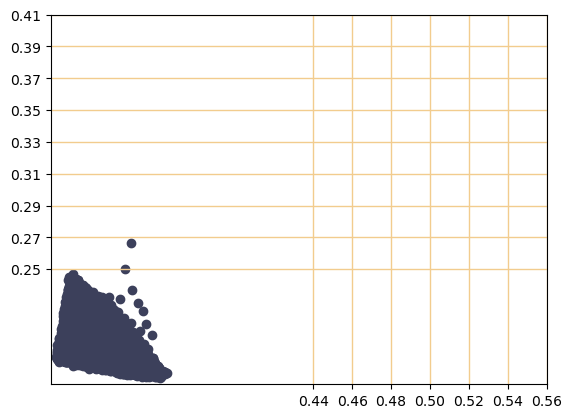

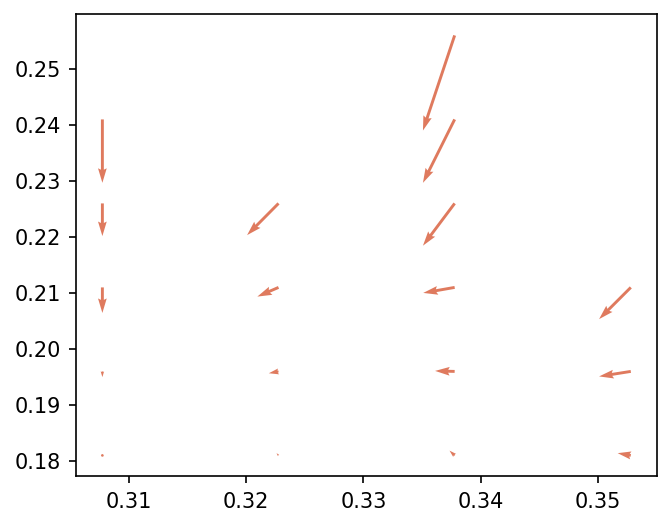

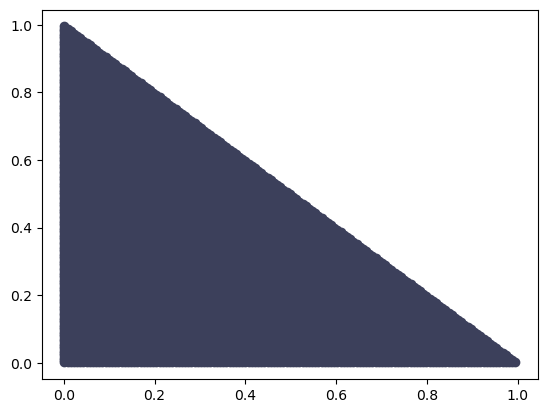

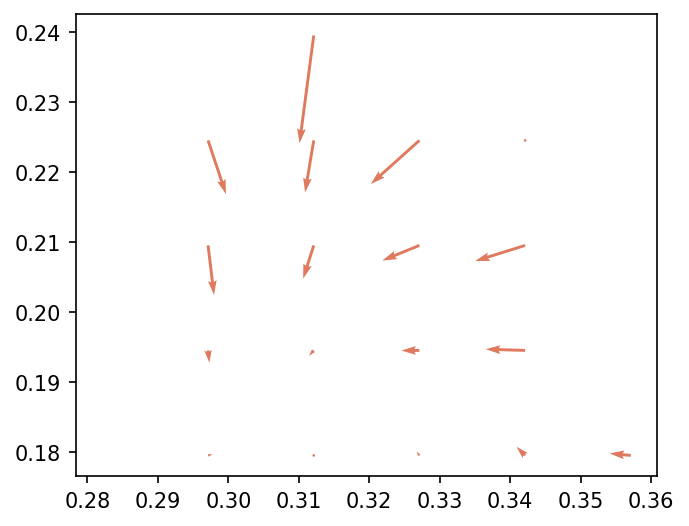

In [12]:
from vector_field import vector_func
sz = 4
scale = 2
L = 1
sigma = 0.03
rou = -0.5
hidden_units = 64
nis = Renorm_Dynamic(sym_size = sz, latent_size = scale, effect_size = sz, 
                         hidden_units = hidden_units, normalized_state=True, device = device)
nisp = Renorm_Dynamic(sym_size = sz, latent_size = scale, effect_size = sz, 
                         hidden_units = hidden_units, normalized_state=True, device = device)
nis.to(device=device)
nisp.to(device=device)
nis.load_state_dict(torch.load('mdl_data/nis steps10 exp-0.2t interval100.mdl'))
nisp.load_state_dict(torch.load('mdl_data/nisp steps10 exp-0.2t interval100.mdl'))



dd1_nis,dd2_nis=vector_func(nis,sigma=sigma,rou=rou, jac_bool=False, density=0.007,density2=0.015,density3=0.07)
dd1_nis_jac,dd2_nis_jac=vector_func(nis,sigma=sigma,rou=rou, jac_bool=True,density=0.007,density2=0.015,density3=0.07)
dd1_nisp,dd2_nisp=vector_func(nisp,sigma=sigma,rou=rou, jac_bool=False,density=0.007,density2=0.015,density3=0.07)
dd1_nisp_jac,dd2_nisp_jac=vector_func(nisp,sigma=sigma,rou=rou, jac_bool=True,density=0.007,density2=0.015,density3=0.07)

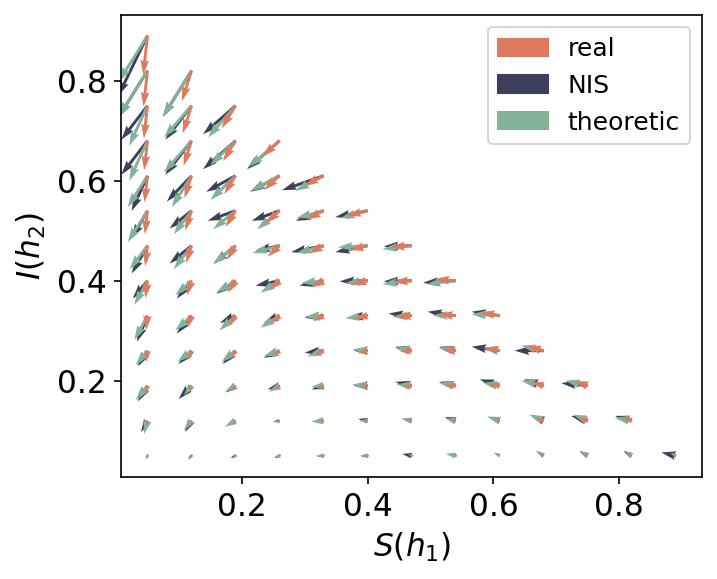

In [13]:
import matplotlib
def SIR(s,i,lam=1,miu=0.5):
    ds=-lam * s * i
    di=lam * s * i - miu * i
    return ds, di
S, I = mesh(0.07)
dSdt,dIdt = SIR(S,I)
m=0.1
dSdt,dIdt=m*dSdt,m*dIdt
fig,ax = plt.subplots(figsize=(5,4),dpi=150)
colorlabel = ['#F4F1DE','#DF7A5E','#3C405B','#82B29A','#F2CC8E']
colors=[colorlabel[2]]*len(S)+[colorlabel[3]]*len(S)+[colorlabel[1]]*len(S)
S=list(S)+list(S)+list(S)
I=list(I)+list(I)+list(I)
dd1_final=list(dd1_nis)+list(dd1_nis_jac)+list(dSdt)
dd2_final=list(dd2_nis)+list(dd2_nis_jac)+list(dIdt)

quiver = ax.quiver(S, I, dd1_final, dd2_final, width=0.005,color=colors)
red_patch = matplotlib.patches.Patch(color=colorlabel[1], label='real')
green_patch = matplotlib.patches.Patch(color=colorlabel[2], label='NIS')
ran_patch = matplotlib.patches.Patch(color=colorlabel[3], label='theoretic')
plt.legend(handles=[red_patch, green_patch,ran_patch],loc='best', fontsize=12)

# Set graphic title and axis labels.
plt.xlabel('$S(h_1)$',fontsize=15)
plt.ylabel('$I(h_2)$',fontsize=15)

ax.tick_params(labelsize=15)
plt.show()

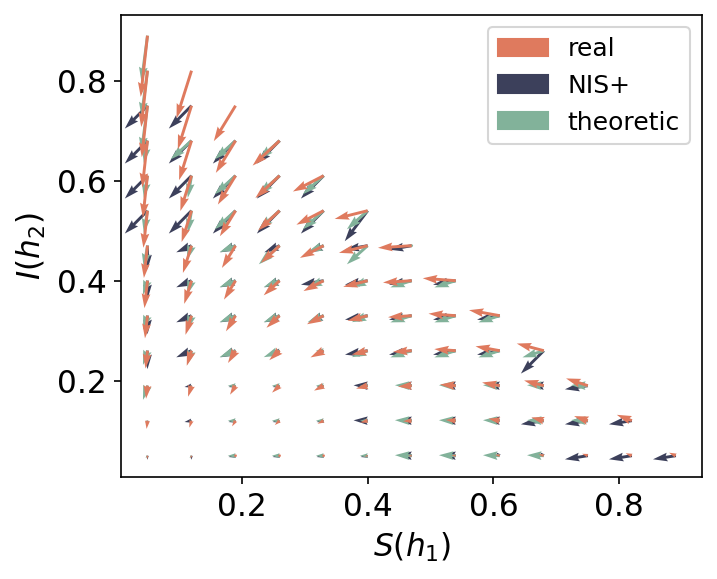

In [14]:
def SIR(s,i,lam=1,miu=0.5):
    ds=-lam * s * i
    di=lam * s * i - miu * i
    return ds, di
S, I = mesh(0.07)
dSdt,dIdt = SIR(S,I)
m=0.1
dSdt,dIdt=m*dSdt,m*dIdt
fig,ax = plt.subplots(figsize=(5,4),dpi=150)
colorlabel = ['#F4F1DE','#DF7A5E','#3C405B','#82B29A','#F2CC8E']
colors=[colorlabel[2]]*len(S)+[colorlabel[3]]*len(S)+[colorlabel[1]]*len(S)
S=list(S)+list(S)+list(S)
I=list(I)+list(I)+list(I)
dd1_final=list(dd1_nisp)+list(dd1_nisp_jac)+list(dSdt)
dd2_final=list(dd2_nisp)+list(dd2_nisp_jac)+list(dIdt)

quiver = ax.quiver(S, I, dd1_final, dd2_final, width=0.005,color=colors)
red_patch = matplotlib.patches.Patch(color=colorlabel[1], label='real')
green_patch = matplotlib.patches.Patch(color=colorlabel[2], label='NIS+')
ran_patch = matplotlib.patches.Patch(color=colorlabel[3], label='theoretic')
plt.legend(handles=[red_patch, green_patch,ran_patch],loc='best', fontsize=12)

# Set graphic title and axis labels.
plt.xlabel('$S(h_1)$',fontsize=15)
plt.ylabel('$I(h_2)$',fontsize=15)

ax.tick_params(labelsize=15)
plt.show()